Encoding features: 100%|██████████| 6/6 [00:01<00:00,  5.45it/s]


Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


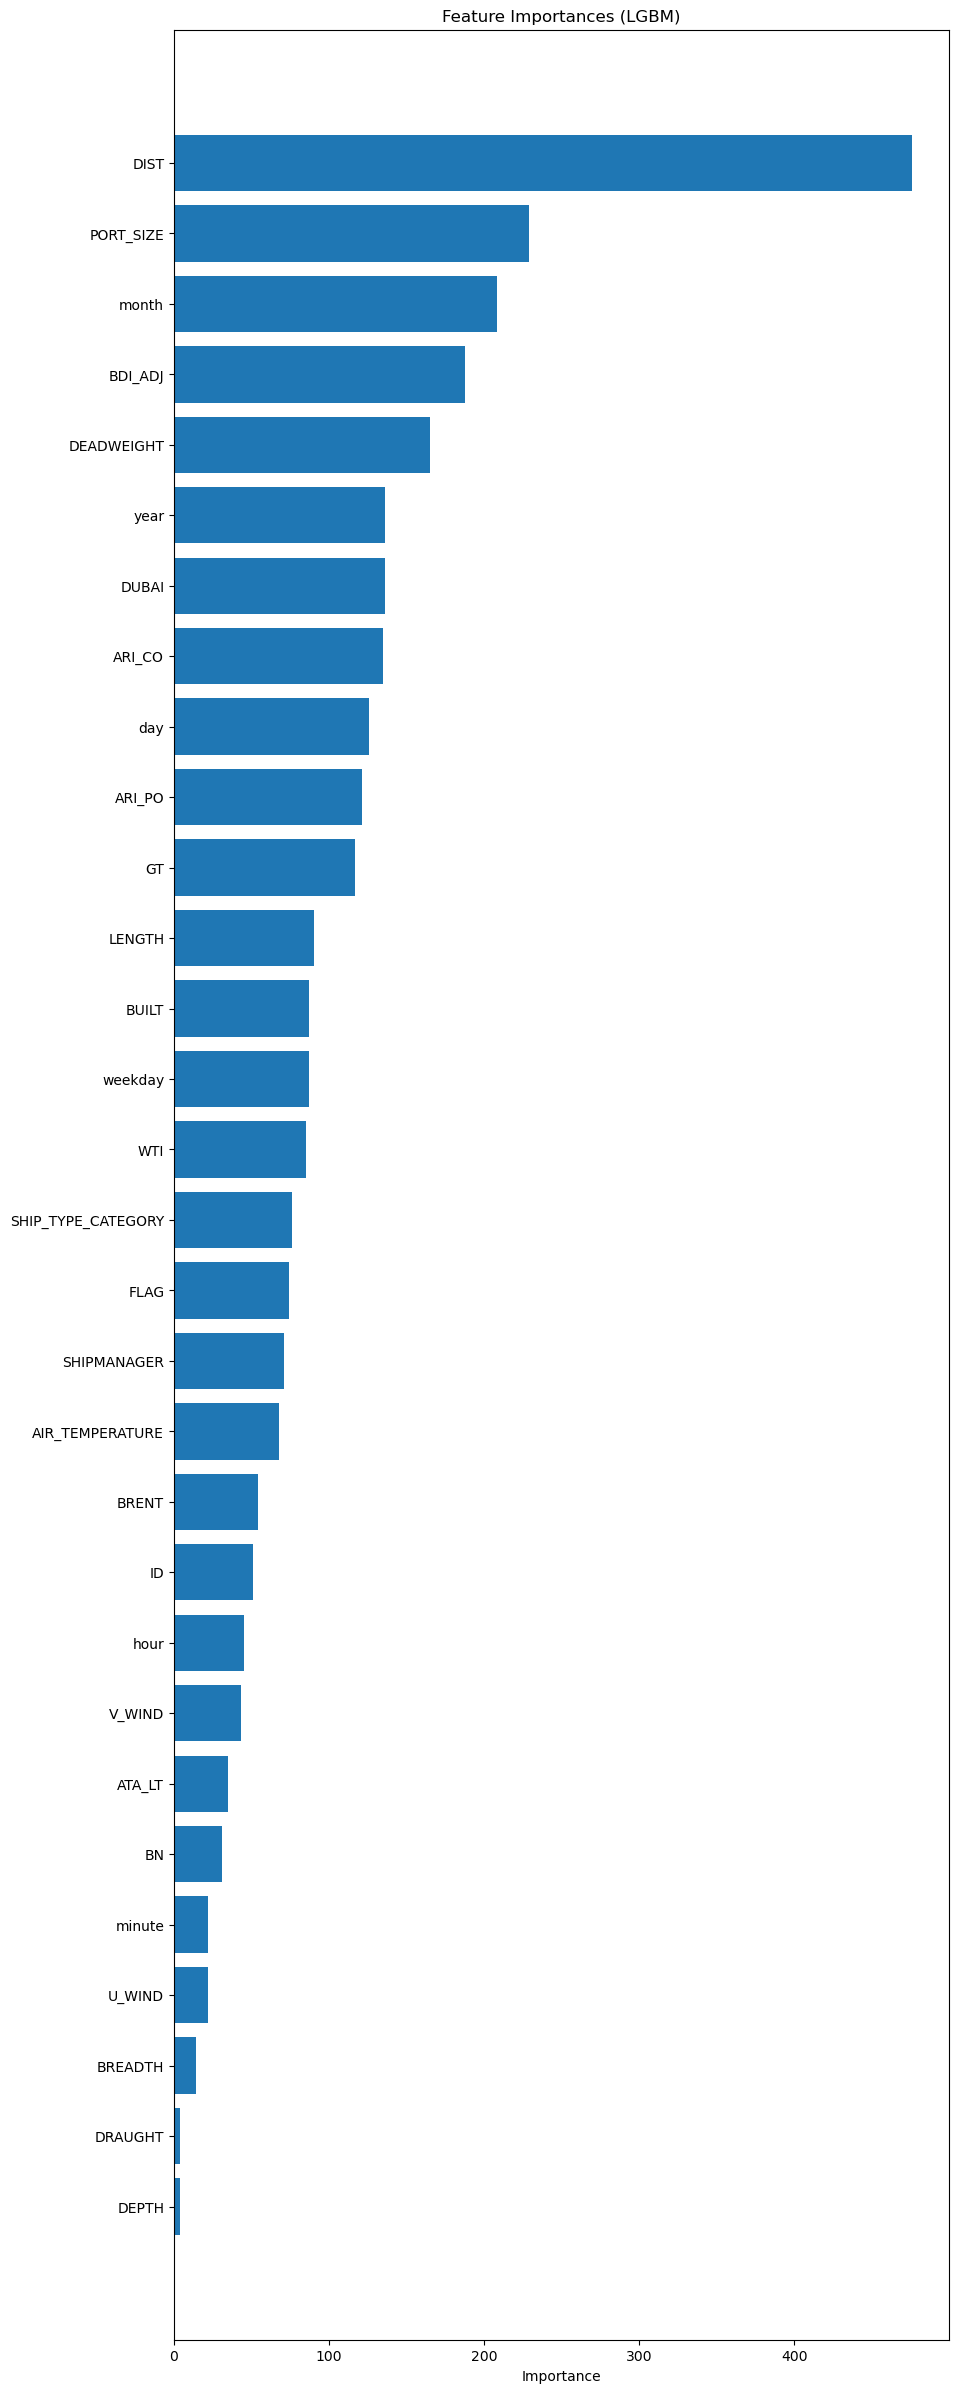

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

train = pd.read_csv('data/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('data/test.csv').drop(columns=['SAMPLE_ID'])






# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])
# datetime을 여러 파생 변수로 변환
## datetime을 학습하기 위해 년 ~ 분까지 데이터를 나눔.
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'AR_IPO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)








def train_and_evaluate(model, model_name, X_train, y_train):
	print(f'Model Tune for {model_name}.')
	model.fit(X_train, y_train)

	feature_importances = model.feature_importances_
	sorted_idx = feature_importances.argsort()

	plt.figure(figsize=(10, len(X_train.columns)))
	plt.title(f"Feature Importances ({model_name})")
	plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
	plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
	plt.xlabel('Importance')
	plt.show()

	return model, feature_importances


X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)


In [55]:
### 하이퍼 파라미터 조정

threshold = 90 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features) # column을 날리는 거라 데이터 개수에 영향 x
# print(X_train_reduced)
# print(X_train_reduced.shape)

X_test_reduced = test.drop(columns=low_importance_features)

lgbm = lgb.LGBMRegressor(random_state=42, num_leaves=250, learning_rate=0.4, n_estimators=2000, boosting_type="dart")

fold_num = 5



In [56]:
##
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 5-Fold 설정
from sklearn.model_selection import StratifiedKFold, KFold
import joblib
from datetime import datetime

kf = KFold(n_splits=fold_num, shuffle=True, random_state=42)
# kf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=42)

start_time = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
MAE = []
count = 0 # 모델 저장용 fold count

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=fold_num, desc="Processing folds"):

	X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
	y_t, y_val = y_train[train_idx], y_train[val_idx]

	# 두 모델 모두 학습
	lgbm.fit(X_t, y_t)

	# 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
	val_pred = lgbm.predict(X_val)

	# Validation set에 대한 대회 평가 산식 계산 후 저장
	mae = mean_absolute_error(y_val, val_pred)
	MAE.append(mae)
	# mae출력
	print(f"MAE : {mae}")

	## 모델 저장 ##
	count += 1
	joblib.dump(lgbm, f"models/lgb_fold_{start_time}---{count}.pkl")


	# test 데이터셋에 대한 예측 수행 후 저장
	lgbm_pred = lgbm.predict(X_test_reduced)
	lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

	ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : NMAE scores for each fold:", MAE)
print("Validation : NMAE:", np.mean(MAE))

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1597
[LightGBM] [Info] Number of data points in the train set: 293952, number of used features: 12
[LightGBM] [Info] Start training from score 62.047288
MAE : 19.02221127380989


Processing folds:  20%|██        | 1/5 [05:15<21:01, 315.34s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1599
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 12
[LightGBM] [Info] Start training from score 61.719969
MAE : 19.023347003974536


Processing folds:  40%|████      | 2/5 [10:32<15:48, 316.15s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1599
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 12
[LightGBM] [Info] Start training from score 61.754815
MAE : 19.145375998845378


Processing folds:  60%|██████    | 3/5 [15:45<10:29, 314.82s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1597
[LightGBM] [Info] Number of data points in the train set: 293953, number of used features: 12
[LightGBM] [Info] Start training from score 61.868218


Processing folds:  60%|██████    | 3/5 [23:17<15:31, 465.98s/it]


KeyboardInterrupt: 

In [ ]:
# xgbr
xgb_pred_list = []
xgb_val_list = []
for n, (tr_idx, val_idx) in enumerate(kf.split(X_train_reduced, y_train)) :
    print(f'{n + 1} FOLD Training.....')
    X_t, X_val = X_train_reduced.iloc[tr_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[tr_idx], y_train[val_idx]

    #############
    xgb = XGBRegressor(random_state = 42, learning_rate=0.4, n_estimators=2000)
    xgb.fit(X_t, y_t)

    val_pred = xgb.predict(X_val)
    val_nmae = mean_absolute_error(y_val, val_pred)
    xgb_val_list.append(val_nmae)
    print(f'{n + 1} FOLD NMAE = {val_nmae}')

    # test 데이터셋에 대한 예측 수행 후 저장
    xgb_pred = xgb.predict(X_test_reduced)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)
    xgb_pred_list.append(xgb_pred)

print(f'10FOLD Mean of NMAE = {np.mean(xgb_val_list)}')

In [70]:
# csv 파일로 만들기
submit = pd.read_csv('data/sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('results/1002_dart_submit_1.csv', index=False)

In [52]:
## 모델 불러오기
load_model = joblib.load('models/lgb.pkl')

In [54]:
load_val_pred = load_model.predict(X_val)
mae = mean_absolute_error(y_val, load_val_pred)
# mae출력
print(f"MAE : {mae}")

MAE : 18.80298191757654
